## Process data

Load the gea data, taking only the 30 most abundant classes.
Here as a new thing I will take 2048 sequence length so it will be split in $4*512$ preds by the model.

Here training and test data is completely balanced (283 observations per class)

**VERY IMPORTANT:** Here, since I cannot find enough stretches without any "N" nucleotide to get this amount of samples for all classes and the model does not support them, I follow this strategy:
 - Take a random sequence that does not have more than 3 Ns, convert the Ns to A residues.
 - There are many sequences without any Ns but I am afraid that if I do this I would be 

**Define total number of samples**. Since 1313 are going to go to test dataset (one for each), I am going to use 8321 in total, because: (8321-1313)/32=219 which is a round number so that our batches are full. So train set is 7008 of size

In [2]:
# set directory of this repo so that all paths can be absolute/relative (not ended with a '/')
path_prefix = '/home/mexposit/cg/gea'

In [3]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

In [4]:
def rev_comp(seq):
    revcomp = ''
    for nt in seq:
        if nt.upper() == 'A':
            revcomp = revcomp+'T'
        elif nt.upper() == 'G':
            revcomp = revcomp+'C'
        elif nt.upper() == 'C':
            revcomp = revcomp+'G'
        elif nt.upper() == 'T':
            revcomp = revcomp+'A'
        else:
            raise ValueError(f'Unrecognized nucleotide {nt}')
    return revcomp[::-1]

In [5]:
rev_comp('ATCG')

'CGAT'

In [6]:
def min_nonN_seq(seq):
    """
    Gets the number of contiguous nucleotides in a sequence that are not N
    """
    seq = seq.upper()
    max_stretch = 0
    cont_len = 0
    for char in seq:
        if char in 'ATCG':
            cont_len += 1
        elif char == 'N':
            # found N, see if contiguous count is larger than previous maximum
            if cont_len > max_stretch:
                max_stretch = cont_len
            # reset to zero
            cont_len = 0
        else:
            raise ValueError(f'Found unrecognized nucleotide {char} in seq {seq}')
    # get stretch if no N has been found
    if max_stretch == 0:
        max_stretch = cont_len
    return max_stretch    

In [7]:
print(min_nonN_seq('ATCGTNATNA'))
print(min_nonN_seq('NNNN'))
print(min_nonN_seq('agtcatc'))

5
0
7


### Load data

In [8]:
train_vals = pd.read_csv(f'{path_prefix}/data/train_values.csv', index_col=0)
train_labl = pd.read_csv(f'{path_prefix}/data/train_labels.csv', index_col=0)

In [9]:
train_vals.head()

,sequence,bacterial_resistance_ampicillin,bacterial_resistance_chloramphenicol,bacterial_resistance_kanamycin,bacterial_resistance_other,bacterial_resistance_spectinomycin,copy_number_high_copy,copy_number_low_copy,copy_number_unknown,growth_strain_ccdb_survival,...,species_budding_yeast,species_fly,species_human,species_mouse,species_mustard_weed,species_nematode,species_other,species_rat,species_synthetic,species_zebrafish
sequence_id,,,,,,,,,,,,,,,,,,,,,
9ZIMC,CATGCATTAGTTATTAATAGTAATCAATTACGGGGTCATTAGTTCA...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5SAQC,GCTGGATGGTTTGGGACATGTGCAGCCCCGTCTCTGTATGGAGTGA...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
E7QRO,NNCCGGGCTGTAGCTACACAGGGCGGAGATGAGAGCCCTACGAAAG...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
CT5FP,GCGGAGATGAAGAGCCCTACGAAAGCTGAGCCTGCGACTCCCGCAG...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
7PTD8,CGCGCATTACTTCACATGGTCCTCAAGGGTAACATGAAAGTGATCC...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
train_labl.head()

,00Q4V31T,012VT4JK,028IO5W2,03GRNN7N,03Y3W51H,09MQV1TY,0A4AHRCT,0A9M05NC,0B9GCUVV,0CL7QVG8,...,ZQNGGY33,ZSHS4VJZ,ZT1IP3T6,ZU6860XU,ZU6TVFFU,ZU75P59K,ZUI6TDWV,ZWFD8OHC,ZX06ZDZN,ZZJVE4HO
sequence_id,,,,,,,,,,,,,,,,,,,,,
9ZIMC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5SAQC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E7QRO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CT5FP,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7PTD8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### There are sequence duplicates, remove them

Aprox 500 entries

In [11]:
train_vals.shape

(63017, 40)

In [12]:
train_vals.drop_duplicates('sequence', inplace=True)

In [13]:
train_vals.shape

(62643, 40)

Also make the change in the labels

In [14]:
train_labl = train_labl.loc[train_vals.index].copy()

In [15]:
train_vals.shape

(62643, 40)

Reverse one hot encoding of labels

In [16]:
labs = train_labl.columns

In [17]:
labels = train_labl.apply(lambda x: labs[np.array(x.values, dtype=bool)][0], axis=1)

### Visualize label imbalance

In [18]:
labels.value_counts()

I7FXTVDP    8226
RKJHZGDQ    2732
GTVTUGVY    2660
A18S09P2    1054
Q2K8NHZY     970
            ... 
G2P73NZ0       3
58BSUZQB       3
WB78G3XF       2
ON9AXMKF       1
0L3Y6ZB2       1
Length: 1314, dtype: int64

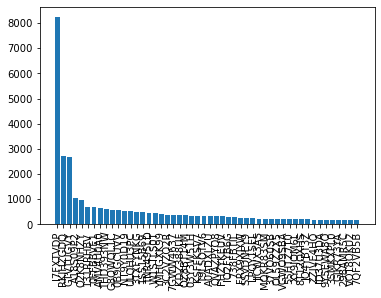

In [19]:
plt.bar(x=labels.value_counts()[:50].index, height=labels.value_counts()[:50].values)
plt.xticks(rotation = 90)
plt.show()

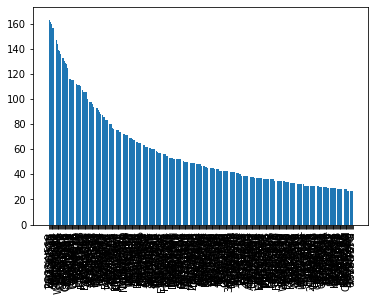

In [20]:
plt.bar(x=labels.value_counts()[50:400].index, height=labels.value_counts()[50:400].values)
plt.xticks(rotation = 90)
plt.show()

More than half of the data has less than 25 sequences

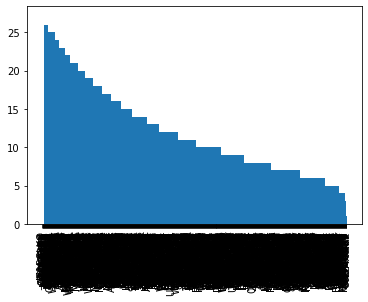

In [21]:
plt.bar(x=labels.value_counts()[400:].index, height=labels.value_counts()[400:].values)
plt.xticks(rotation = 90)
plt.show()

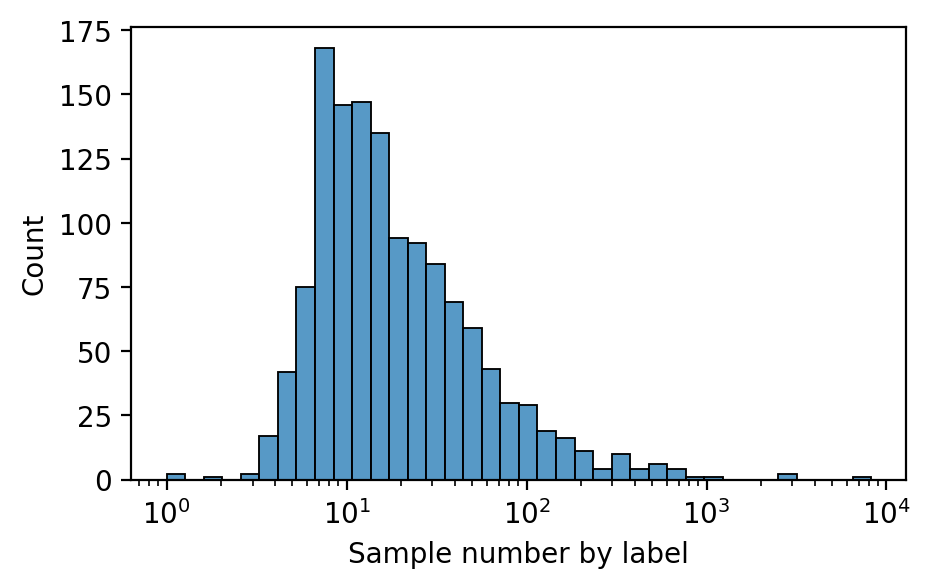

In [37]:
plt.figure(figsize=(5,3), dpi=200)
sns.histplot(labels.value_counts(), log_scale=True)
plt.xlabel('Sample number by label')
plt.show()

### Partially balancing the dataset

If I use weights INVERSELY proportional to the number of original samples, I get lots of samples of the ones that had very few examples and data becomes very imbalanced but the other way around.

Define total number of samples. Since 1313 are going to go to test dataset (one for each), I am going to use 8321 in total, because: (8321-1313)/32=219 which is a round number so that our batches are full

In [38]:
num_samples = 8321

In [39]:
lab_value_cts = labels.value_counts()
lab_ids = lab_value_cts.index
lab_val = lab_value_cts.values

In [40]:
weights = [1/weig for weig in (lab_val)]
weights = weights / np.sum(weights) #normalize to 1
lab_dist = np.random.choice(lab_ids, size=num_samples, p=weights)

In [41]:
resampl = pd.Series(lab_dist, name='resampled').value_counts()

In [42]:
comp = pd.DataFrame(lab_value_cts, columns=['original']).join(resampl)

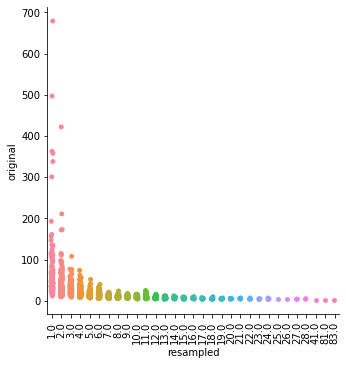

In [43]:
sns.catplot(x='resampled', y='original', data=comp)
plt.xticks(rotation=90)
plt.show()

I can follow another strategy, which is summing a value orders of magnitude larger than the most abundant sample to decrease the differences between samples, this way I don't need to inverse it. Still more abundant samples are somewhat more likely (not much) to have more samples than the less abundant 

In [50]:
weights = [weig for weig in (lab_val + 50000)]
weights = weights / np.sum(weights) #normalize to 1
np.random.seed(42)
lab_dist = np.random.choice(lab_ids, size=num_samples, p=weights)

In [51]:
len(lab_dist)

8321

In [52]:
lab_dist = pd.Series(lab_dist, name='Samples by label in resampled data').value_counts()

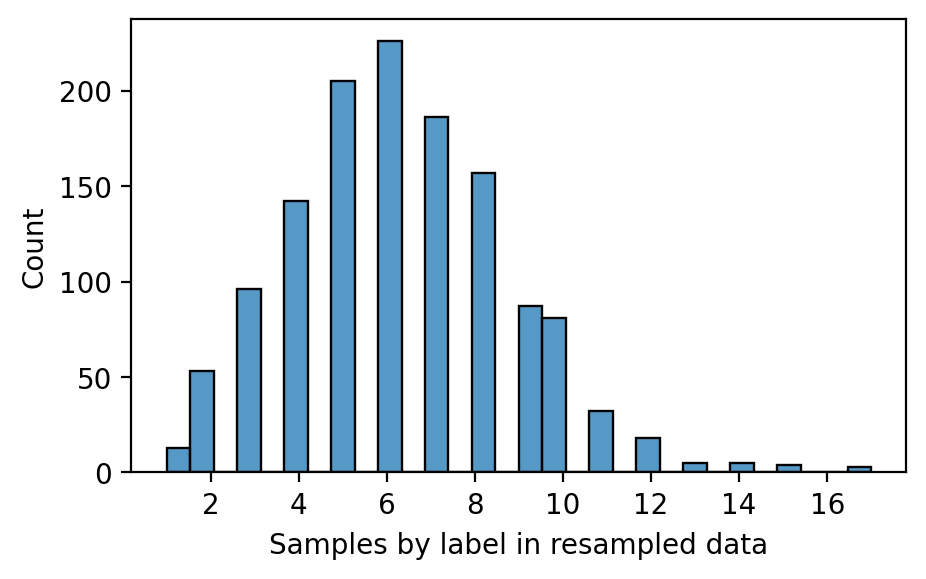

In [53]:
plt.figure(figsize=(5,3), dpi=200)
sns.histplot(lab_dist)
plt.show()

In [32]:
comp = pd.DataFrame(lab_value_cts, columns=['original']).join(lab_dist)

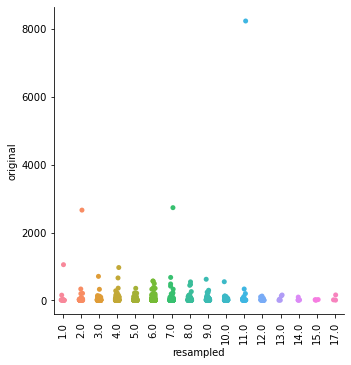

In [33]:
sns.catplot(x='resampled', y='original', data=comp)
plt.xticks(rotation=90)
plt.show()

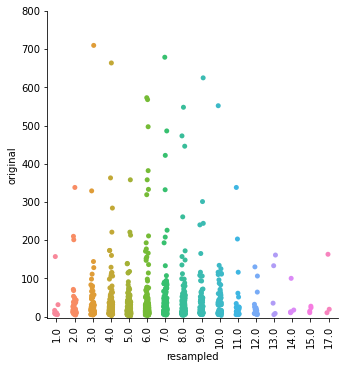

In [34]:
sns.catplot(x='resampled', y='original', data=comp)
plt.xticks(rotation=90)
plt.ylim(-5,800)
plt.show()

**So the dataset is still imbalanced but much less imbalanced. Depending on the number of available samples for each label I may be oversampling or undersampling it.**

### Getting subsequences

Calculate some values that are useful

In [35]:
train_vals['seq_len'] = [len(seq) for seq in train_vals['sequence']]

In [36]:
# get the maximum length of contiguous sequence without any undefined nucleotide
train_vals['min_nonN_seq'] = [min_nonN_seq(seq) for seq in train_vals['sequence']]

In [37]:
# number of N per sequence
train_vals['undefval'] = [seq.upper().count('N') for seq in train_vals['sequence']]

In [38]:
train_vals['label'] = labels

In [39]:
min_len = 512

In [40]:
sele_train = []

prob=0
prob_repe=0
for lab, num in lab_dist.iteritems():
    subset = train_vals[(train_vals['min_nonN_seq'] > min_len) & (train_vals['label'] == lab) ].copy()
    if len(subset) >= num:
        # enough longer sequences without N, just randomly sample
        sele_train.append(subset.sample(n=num, replace=False, random_state=42))
#         print(f'Label {lab} processed without having to pad or remove Ns')
    else:
        # count labels that have problems finding sequences
        prob+=1
        # discard all sequences with more than 10 Ns
        subset = train_vals[(train_vals['undefval'] <= 10) & (train_vals['label'] == lab) ].copy()
        # replace all the N nucleotides in the sequences by As
        subset['sequence'] = [seq.upper().replace('N','A') for seq in subset['sequence']]
        try:
            # avoid replacements if there are enough, try to get longer sequences using weights
            sele_subset = subset.sample(n=num, replace=False, random_state=42, weights=subset['seq_len'])
#             print(f'Label {lab} replaced Ns and pad if necesary, but no replacements')
        except:
            prob_repe+=1
            # do replacements if some lack sequences, but avoid repeting as much as possible by not using weights
            sele_subset = subset.sample(n=num, replace=True, random_state=42)
#             print(f'Label {lab} replaced Ns and pad if necesary, and had to include replacements')
        sele_train.append(sele_subset)

In [41]:
print(f'Found {prob} labels that did not have a {min_len}bp sequence without Ns,')
print('so had to replace some Ns by As (less than 10Ns replaced per sequence for sure)')
print(f'Of those, {prob_repe} labels had to use repeated samples, so they were here bc could not find so many samples')

Found 126 labels that did not have a 512bp sequence without Ns,
so had to replace some Ns by As (less than 10Ns replaced per sequence for sure)
Of those, 121 labels had to use repeated samples, so they were here bc could not find so many samples


In [42]:
sele_train = pd.concat(sele_train)

In [43]:
sele_train

,sequence,bacterial_resistance_ampicillin,bacterial_resistance_chloramphenicol,bacterial_resistance_kanamycin,bacterial_resistance_other,bacterial_resistance_spectinomycin,copy_number_high_copy,copy_number_low_copy,copy_number_unknown,growth_strain_ccdb_survival,...,species_mustard_weed,species_nematode,species_other,species_rat,species_synthetic,species_zebrafish,seq_len,min_nonN_seq,undefval,label
sequence_id,,,,,,,,,,,,,,,,,,,,,
R8D86,GACGAAAGGGCCTCGTGATACGCCTATTTTTATAGGTTAATGTCAT...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,6645,6645,0,XV32YHEZ
WOAGB,GACGAAAGGGCCTCGTGATACGCCTATTTTTATAGGTTAATGTCAT...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,7859,7859,0,XV32YHEZ
RPHFD,TCGCGCGTTTCGGTGATGACGGTGAAAACCTCTGACACATGCAGCT...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,7912,7912,0,XV32YHEZ
JCE9W,GACGAAAGGGCCTCGTGATACGCCTATTTTTATAGGTTAATGTCAT...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,7270,7270,0,XV32YHEZ
4KHKK,GACGAAAGGGCCTCGTGATACGCCTATTTTTATAGGTTAATGTCAT...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,7470,7470,0,XV32YHEZ
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
B592R,GAATTCGAGCTTGCATGCCTGCAGGTCGTTACATAACTTACGGTAA...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,5109,5109,0,2Y9L13L4
OXMIV,CCGGGGANGCTCCTCGCCCTTGCTCACCATGGTGGCGACCGGTGGA...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,670,646,4,1AP294AT
S6OT6,CTTTCCTGCGTTATCCCCTGATTCTGTGGATAACCGTATTACCGCC...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3366,3366,0,A18S09P2


Confirm those two are equal

In [44]:
lab_dist

XV32YHEZ    17
HGPS0FQN    17
HVAG84XI    17
97PR85CP    15
4M3XG8RC    15
            ..
2Y9L13L4     1
1AP294AT     1
A18S09P2     1
XOEVMQZT     1
Q5V3EKJC     1
Name: resampled, Length: 1313, dtype: int64

In [45]:
sele_train.label.value_counts()

XV32YHEZ    17
HVAG84XI    17
HGPS0FQN    17
97PR85CP    15
4M3XG8RC    15
            ..
J9M11KX1     1
IPVYEI8G     1
46AZ97U9     1
CFDEOSH4     1
Q5V3EKJC     1
Name: label, Length: 1313, dtype: int64

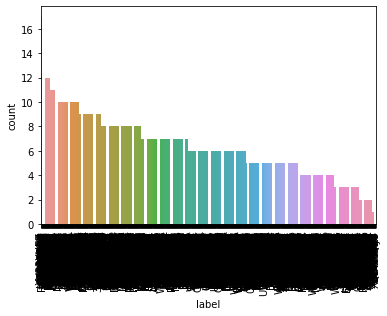

In [46]:
sns.countplot(x='label', data=sele_train)
plt.xticks(rotation=90)
plt.show()

### Get subsequences

For each sequence, take 1 subsequence randomly with random Reverse Translatation

In [47]:
num_subseq_per_seq = 1
seq_len = min_len


random_seq_sele = []

np.random.seed(42)

for seq in sele_train['sequence']:
    sub_list = []
    for _ in range(num_subseq_per_seq):
        # if sequence is shorter, take entire sequence and it will be padded
        # if it has a N on it, this is a problem and would be better to manually analyze and discard this observation before running cell
        if len(seq) <= seq_len:
            if 'N' in seq.upper(): 
                raise ValueError("Can't process sequences, found a sequence shorter than seq_len and with a N character...discard this sequence")
            # with probability 0.5 make the Reverse Complement of that sequence
            if np.random.rand() > .5:
                sub_list.append(seq)
            else:
                sub_list.append(rev_comp(seq))
        else:
            # if sequence is longer, need to randomly select a subsequence
            subseq ='' # initialize to enter while
            # keep looking for subsequences until they do not have any N (this might bias a bit the initial positions)
            while ('N' in subseq.upper()) or (len(subseq) != seq_len):
                start_pos = np.random.randint(len(seq) - seq_len + 1)
                subseq = seq[start_pos:start_pos+seq_len]
            # with probability 0.5 make the Reverse Complement of that sequence
            if np.random.rand() > .5:
                sub_list.append(subseq)
            else:
                sub_list.append(rev_comp(subseq))
    random_seq_sele.append(sub_list)

In [48]:
# 8 subsequences per each sequence
print('Got:', np.array(random_seq_sele).shape)

Got: (8321, 1)


In [49]:
sele_train['random_seq_sele'] = random_seq_sele

there are 100 repeats in this subset, not a problem, it can just happen by random selection and it is not much compared to 8000 total examples


In [50]:
print(sele_train['random_seq_sele'].shape)
print(np.sum(sele_train['random_seq_sele'].value_counts() > 1))

(8321,)
132


Number of repeated sequences divided by class. Not many compared to 283 seqs we have per class

In [51]:
rep_seqs = []
for lab in lab_dist.index:
    rep_seqs.append(np.sum(sele_train[sele_train['label'] == lab]['random_seq_sele'].value_counts() > 1))

They are repeated in the sample that was short on sequences

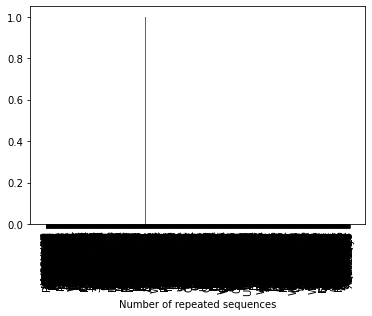

In [52]:
plt.bar(x=lab_dist.index, height=rep_seqs)
plt.xticks(rotation=90)
plt.xlabel('Number of repeated sequences')
plt.show()

Number of sequences that will require padding

In [53]:
sele_train['sele_seq_len'] = sele_train['random_seq_sele'].apply(lambda x: len(x[0]))

The maximum per class is 4 that will require padding. This could be a lot depending on total number of seqs for that class that is around mean 10

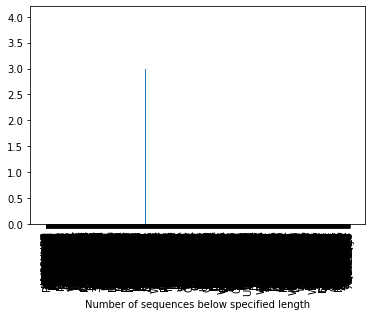

In [54]:
pad_seqs = []
for lab in lab_dist.index:
    pad_seqs.append(np.sum(sele_train[sele_train['label'] == lab]['sele_seq_len'] < min_len))
plt.bar(x=lab_dist.index, height=pad_seqs)
plt.xticks(rotation=90)
plt.xlabel('Number of sequences below specified length')
plt.show()

In [55]:
max(pad_seqs)

4

In [56]:
# too many classes to represent with this
# fig, axs = plt.subplots(6,5, figsize=(14,8), sharex=True)
# axs = axs.flatten()
# for i, lab in enumerate(sele_labs):
#     sns.histplot(sele_train[sele_train['label'] == lab]['sele_seq_len'], ax=axs[i])
#     axs[i].set_title(lab)
# plt.tight_layout()
# plt.show()

### Convert labels to integer values

In [57]:
label_key = {}
for i, lab in enumerate(lab_dist.index):
    label_key[lab] = str(i)

In [58]:
len(label_key)

1313

In [59]:
# convert label name to an integer
sele_train['bin_label'] = [label_key[lab] for lab in sele_train['label']]

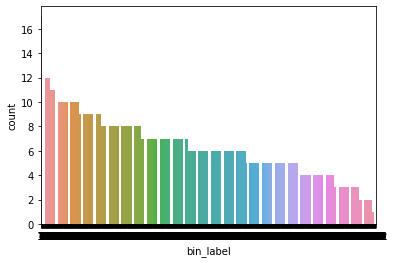

In [60]:
sns.countplot(x='bin_label', data=sele_train)
plt.show()

## Conver to kmers

In [61]:
kmer_size = 6

Use their function seq2kmer from `motif/motif_utils.py`

In [62]:
def seq2kmer(seq, k):
    """
    Convert original sequence to kmers
    
    Arguments:
    seq -- str, original sequence.
    k -- int, kmer of length k specified.
    
    Returns:
    kmers -- str, kmers separated by space

    """
    kmer = [seq[x:x+k] for x in range(len(seq)+1-k)]
    kmers = " ".join(kmer)
    return kmers

Example

In [63]:
sele_train['kmer_rand'] = [[seq2kmer(seq, kmer_size) for seq in subseq] for subseq in sele_train['random_seq_sele']]

In [64]:
sele_train['kmer_rand']

sequence_id
R8D86    [GCAGAA CAGAAG AGAAGT GAAGTG AAGTGG AGTGGT GTG...
WOAGB    [ACGCCA CGCCAT GCCATT CCATTA CATTAA ATTAAC TTA...
RPHFD    [TGGGTT GGGTTA GGTTAC GTTACA TTACAT TACATC ACA...
JCE9W    [TTGTTT TGTTTT GTTTTC TTTTCA TTTCAA TTCAAG TCA...
4KHKK    [TGCGGG GCGGGA CGGGAG GGGAGG GGAGGT GAGGTG AGG...
                               ...                        
B592R    [GATTAG ATTAGG TTAGGA TAGGAG AGGAGG GGAGGA GAG...
OXMIV    [TTTCAT TTCATG TCATGA CATGAC ATGACC TGACCC GAC...
S6OT6    [GGCAGA GCAGAG CAGAGG AGAGGA GAGGAC AGGACT GGA...
TLTV7    [TAAGAG AAGAGA AGAGAA GAGAAT AGAATT GAATTA AAT...
R2VAV    [CACAGA ACAGAG CAGAGA AGAGAA GAGAAA AGAAAG GAA...
Name: kmer_rand, Length: 8321, dtype: object

In [65]:
sele_train['kmer_rand'].values[0]

['GCAGAA CAGAAG AGAAGT GAAGTG AAGTGG AGTGGT GTGGTC TGGTCC GGTCCT GTCCTG TCCTGC CCTGCA CTGCAA TGCAAC GCAACT CAACTT AACTTT ACTTTA CTTTAT TTTATC TTATCC TATCCG ATCCGC TCCGCC CCGCCT CGCCTC GCCTCC CCTCCA CTCCAT TCCATC CCATCC CATCCA ATCCAG TCCAGT CCAGTC CAGTCT AGTCTA GTCTAT TCTATT CTATTA TATTAA ATTAAT TTAATT TAATTG AATTGT ATTGTT TTGTTG TGTTGC GTTGCC TTGCCG TGCCGG GCCGGG CCGGGA CGGGAA GGGAAG GGAAGC GAAGCT AAGCTA AGCTAG GCTAGA CTAGAG TAGAGT AGAGTA GAGTAA AGTAAG GTAAGT TAAGTA AAGTAG AGTAGT GTAGTT TAGTTC AGTTCG GTTCGC TTCGCC TCGCCA CGCCAG GCCAGT CCAGTT CAGTTA AGTTAA GTTAAT TTAATA TAATAG AATAGT ATAGTT TAGTTT AGTTTG GTTTGC TTTGCG TTGCGC TGCGCA GCGCAA CGCAAC GCAACG CAACGT AACGTT ACGTTG CGTTGT GTTGTT TTGTTG TGTTGC GTTGCC TTGCCA TGCCAT GCCATT CCATTG CATTGC ATTGCT TTGCTA TGCTAC GCTACA CTACAG TACAGG ACAGGC CAGGCA AGGCAT GGCATC GCATCG CATCGT ATCGTG TCGTGG CGTGGT GTGGTG TGGTGT GGTGTC GTGTCA TGTCAC GTCACG TCACGC CACGCT ACGCTC CGCTCG GCTCGT CTCGTC TCGTCG CGTCGT GTCGTT TCGTTT CGTTTG GTTTGG TTTGGT TTGGTA TGGT

In [66]:
6*(512-5)+(512-5)-1 # last kmer does not have end space

3548

In [67]:
len(sele_train['kmer_rand'].values[0][0])

3548

Now, I need to get individual subsequence kmer represnetations as each row

In [68]:
final_data = []

for seq_idx, row in sele_train.iterrows():
    bin_label = row['bin_label']
    for seq in row['kmer_rand']:
        final_data.append({
            'sequence_id': seq_idx,
            'sequence': seq,
            'label': bin_label
        })

final_data = pd.DataFrame.from_records(final_data)

In [69]:
final_data.shape

(8321, 3)

In [70]:
final_data.set_index('sequence_id', inplace=True)

In [71]:
final_data

,sequence,label
sequence_id,,
R8D86,GCAGAA CAGAAG AGAAGT GAAGTG AAGTGG AGTGGT GTGG...,0
WOAGB,ACGCCA CGCCAT GCCATT CCATTA CATTAA ATTAAC TTAA...,0
RPHFD,TGGGTT GGGTTA GGTTAC GTTACA TTACAT TACATC ACAT...,0
JCE9W,TTGTTT TGTTTT GTTTTC TTTTCA TTTCAA TTCAAG TCAA...,0
4KHKK,TGCGGG GCGGGA CGGGAG GGGAGG GGAGGT GAGGTG AGGT...,0
...,...,...
B592R,GATTAG ATTAGG TTAGGA TAGGAG AGGAGG GGAGGA GAGG...,1308
OXMIV,TTTCAT TTCATG TCATGA CATGAC ATGACC TGACCC GACC...,1309
S6OT6,GGCAGA GCAGAG CAGAGG AGAGGA GAGGAC AGGACT GGAC...,1310


## Split data

Original finetuning data is split between a dev.tsv file with 1000 observations and a train.tsv file with 32367 observations. I think the dev set is used during training to evaluate the accuracy on a held-out dataset (test accuracy). 

**SINCE I AM NOT COMPARING MODELS BETWEEN THEM, BECAUSE THE DATA I USE IN EVERYONE IS DIFFEERENT, THERE IS NO USE FOR A TRAIN DATASET THAT IS NOT USED TO EVALUATE OR CHOOSE HYPERPARAMETERS OF THE MODEL AND IS ONLY USED TO COMPARE ACROSS MODELS, HENCE IT IS FINE TO JUST USE THE DEV SET, WHICH IS NOT USED DURING FINETUNING TO SET ANY KIND OF PARAMETER**

I create a column with unique id for each observation, since I have repeated samples (and hence repeated indices) just looking at the indices would not work

In [72]:
final_data['num'] = [i for i in range(0,len(final_data))]

I pick a random sequence from each class to form a 1313 sized test dataset

In [73]:
dev_data = final_data.groupby('label').sample(1, replace=False, random_state=42).copy()

to get the train_data I need to make a list from 0 to len(train_data) excluding those indices in dev_data

In [74]:
# I cannot do it like this because there are repeated values
# train_data = final_data[~(final_data.index.isin(dev_data.index))].copy()
train_data = final_data[~(final_data['num'].isin(dev_data['num']))].copy()

We can see how dev_data has one of every

In [75]:
dev_data['label'].value_counts().value_counts()

1    1313
Name: label, dtype: int64

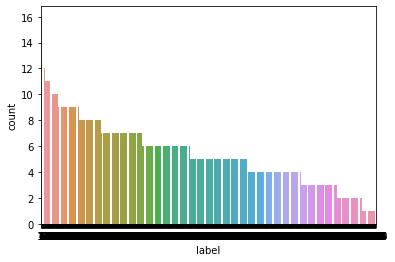

In [76]:
sns.countplot(x='label', data=train_data)
plt.show()

In [77]:
dev_data

,sequence,label,num
sequence_id,,,
R8D86,GCAGAA CAGAAG AGAAGT GAAGTG AAGTGG AGTGGT GTGG...,0,0
9UVU3,TCTAGT CTAGTG TAGTGT AGTGTA GTGTAG TGTAGC GTAG...,1,31
6OCLU,TGACAG GACAGT ACAGTA CAGTAA AGTAAG GTAAGA TAAG...,10,154
TJENW,CTGAAA TGAAAC GAAACA AAACAT AACATG ACATGG CATG...,100,1149
S12LH,ATGGAA TGGAAA GGAAAA GAAAAA AAAAAC AAAACG AAAC...,1000,7303
...,...,...,...
UVUIH,TTTGTG TTGTGA TGTGAA GTGAAA TGAAAT GAAATT AAAT...,995,7278
BQK05,TACTAG ACTAGT CTAGTA TAGTAT AGTATT GTATTG TATT...,996,7283
9LL82,AGCGGT GCGGTC CGGTCA GGTCAC GTCACG TCACGC CACG...,997,7289


In [78]:
train_data

,sequence,label,num
sequence_id,,,
WOAGB,ACGCCA CGCCAT GCCATT CCATTA CATTAA ATTAAC TTAA...,0,1
RPHFD,TGGGTT GGGTTA GGTTAC GTTACA TTACAT TACATC ACAT...,0,2
JCE9W,TTGTTT TGTTTT GTTTTC TTTTCA TTTCAA TTCAAG TCAA...,0,3
4KHKK,TGCGGG GCGGGA CGGGAG GGGAGG GGAGGT GAGGTG AGGT...,0,4
2YETQ,GTTTCT TTTCTG TTCTGA TCTGAA CTGAAA TGAAAC GAAA...,0,5
...,...,...,...
1C0DS,TGGGGA GGGGAC GGGACA GGACAT GACATC ACATCA CATC...,1295,8299
GUNZQ,ACAGGA CAGGAA AGGAAA GGAAAA GAAAAA AAAAAA AAAA...,1296,8300
JWAU8,AAATGG AATGGA ATGGAG TGGAGC GGAGCA GAGCAA AGCA...,1297,8302


Drop num column

In [87]:
dev_data.drop(labels='num',axis=1, inplace=True)

In [88]:
train_data.drop(labels='num',axis=1, inplace=True)

### Shuffle

As it is now, observations are ordered by label. Will shuffle it just in case the model does not shuffle input data to take the 32 batch sizes (I bet it does)

In [89]:
train_data = train_data.sample(frac=1, random_state=42)

In [90]:
dev_data

,sequence,label
sequence_id,,
UPK17,GGCTGG GCTGGC CTGGCT TGGCTG GGCTGG GCTGGT CTGG...,1043
JEGY9,AAGAGT AGAGTA GAGTAA AGTAAT GTAATT TAATTG AATT...,181
NDPSH,AAACTT AACTTG ACTTGA CTTGAT TTGATT TGATTA GATT...,466
VZS7T,AACCGT ACCGTA CCGTAA CGTAAA GTAAAA TAAAAA AAAA...,253
LH1AF,ATGCTT TGCTTA GCTTAA CTTAAT TTAATC TAATCA AATC...,877
...,...,...
JMQU6,AATACA ATACAA TACAAC ACAACC CAACCT AACCTA ACCT...,802
1XTUU,GTGGTT TGGTTC GGTTCT GTTCTG TTCTGC TCTGCT CTGC...,834
013DI,GATCTG ATCTGA TCTGAT CTGATG TGATGG GATGGC ATGG...,982


In [91]:
dev_data = dev_data.sample(frac=1, random_state=42)

In [92]:
dev_data

,sequence,label
sequence_id,,
KT1RZ,TACTCT ACTCTT CTCTTC TCTTCC CTTCCT TTCCTT TCCT...,187
NPRCX,AATACG ATACGA TACGAC ACGACT CGACTC GACTCA ACTC...,451
DJUUX,GCCTCT CCTCTT CTCTTC TCTTCG CTTCGC TTCGCT TCGC...,724
5KKO0,CGGACT GGACTG GACTGT ACTGTT CTGTTG TGTTGG GTTG...,896
F5VM2,TGAAGG GAAGGG AAGGGC AGGGCA GGGCAA GGCAAT GCAA...,302
...,...,...
PLLPV,TCATGG CATGGC ATGGCC TGGCCT GGCCTA GCCTAC CCTA...,1045
WW475,TGTGTT GTGTTC TGTTCC GTTCCA TTCCAG TCCAGG CCAG...,1126
77RBU,CGGCTG GGCTGC GCTGCG CTGCGG TGCGGC GCGGCG CGGC...,910


### Export

Finally, export this dataframes in the appropriate format and in a .csv file that could be read back to pandas (which contains information about the indices!)

In [93]:
train_data.to_csv(f'{path_prefix}/transformers/7_gea500/in_data/train_data.csv')
dev_data.to_csv(f'{path_prefix}/transformers/7_gea500/in_data/dev_data.csv')

Model will use these tsv files.

In [94]:
train_data.to_csv(f'{path_prefix}/transformers/7_gea500/in_data/train.tsv', sep='\t', index=False)
dev_data.to_csv(f'{path_prefix}/transformers/7_gea500/in_data/dev.tsv', sep='\t', index=False)

Also export the key to relate each numeric label to each class name

In [95]:
with open(f'{path_prefix}/transformers/7_gea500/in_data/label_key.csv','w') as f:
    f.write('label_name label_num\n')
    for name, num in label_key.items():
        f.write(f'{name} {num}\n')